<h1 style='font-size:20px;text-align:center'>
How to discriminate liquid and ice monolayer clouds for Aqua/Modis<br>using a deep learning algorithm based on TensorFlow ?</h1>

<p style='text-align: center'>
Author: Benjamin Marchant 
<br>(marchant.benjamin01@gmail.com)
<br>(benjamin.marchant@nasa.gov)
<br> Last Update: 2020-10-28
</p>

Note: Project can also be downloaded from [Github](https://github.com/benjamin-hg-marchant/ml-dl-modis-multilayer-clouds)


Table of Content:

* [Read MODIS CALIOP CLoudSat Co-located Dataset](#dataset)
* [Create cloud phase & multilayer cloud labels](#labels) 

In [61]:
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pandas as pd
import numpy as np
import numpy.ma as ma
import seaborn as sns; sns.set()
import seaborn as sn
import datetime 
import urllib.request
import urllib.request, json 
import os
import glob
import pprint
import warnings
import h5py

from tensorflow import keras
from tensorflow.keras import layers
from matplotlib.pyplot import figure
from IPython.core.display import HTML
from pyhdf.SD import SD, SDC 
from sklearn import preprocessing
from graphviz import Digraph
from graphviz import Source
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay    
from sklearn.metrics import average_precision_score
from datetime import date
from calendar import monthrange
from os import path

warnings.filterwarnings('ignore')

In [62]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [63]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [148]:
f = open('/Users/mb/Desktop/mb_root/media/auth/data.txt', 'r')

auth_pwd = f.read()

f.closed

False

In [149]:
opener = urllib.request.build_opener()
opener.addheaders = [('Authorization', '{}'.format(auth_pwd))]
urllib.request.install_opener(opener)

In [65]:
year = 2008
month = 1

In [66]:
with pd.HDFStore('inputs/random_sample_modis_caliop_cloudsat_{:04d}_{:02d}.hdf5'.format(year,month)) as store:
    print(store.keys())
    df = store['random_sample']

['/random_sample']


In [67]:
df.shape

(61613, 115)

In [68]:
df.head(10)

,modis_multilayer_cloud,modis_multilayer_cloud_qa1,modis_multilayer_cloud_qa2,modis_multilayer_cloud_qa3,modis_multilayer_cloud_qa4,modis_multilayer_cloud_qa5,modis_cloud_phase,latitude,longitude,modis_cloud_top_height_1km,...,cloud_layer_optical_depth_09,cloud_layer_phase_09,cloud_layer_source_09,cloud_layer_top_10,cloud_layer_base_10,cloud_layer_optical_depth_10,cloud_layer_phase_10,cloud_layer_source_10,label 1,label 2
0,5.0,1.0,0.0,0.0,0.0,1.0,2.0,-49.767658,-144.492096,2700.0,...,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0,monolayer (n=1),mixed
1,1.0,0.0,0.0,0.0,0.0,0.0,2.0,7.892334,87.800476,4750.0,...,0.0,3.0,3.0,0.0,0.0,-9999.0,0.0,0.0,multilayer (n>2),unlabeled
3,1.0,0.0,0.0,0.0,0.0,0.0,2.0,28.681301,-40.599194,50.0,...,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0,monolayer (n=1),liquid
4,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-67.958023,-82.737038,1250.0,...,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0,monolayer (n=1),liquid
5,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-60.335007,-138.910355,850.0,...,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0,monolayer (n=1),liquid
6,8.0,0.0,1.0,1.0,0.0,1.0,3.0,-63.907398,36.836395,7450.0,...,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0,multilayer (n=2),ice / mixed
8,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-16.378271,-30.564116,2800.0,...,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0,monolayer (n=1),liquid
12,4.0,0.0,0.0,0.0,0.0,1.0,3.0,29.086929,-114.863945,10100.0,...,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0,unlabeled,unlabeled
15,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-51.499092,54.019638,900.0,...,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0,monolayer (n=1),liquid
19,1.0,0.0,0.0,0.0,0.0,0.0,2.0,44.663315,152.396622,700.0,...,-9999.0,0.0,0.0,0.0,0.0,-9999.0,0.0,0.0,monolayer (n=1),liquid


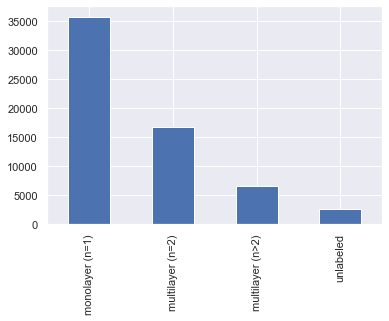

In [69]:
df['label 1'].value_counts().plot(kind='bar')

plt.show()

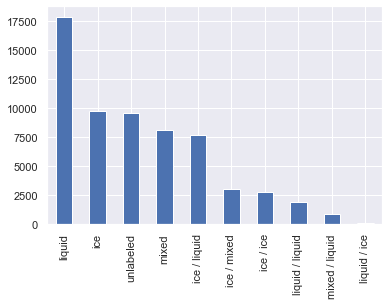

In [70]:
df['label 2'].value_counts().plot(kind='bar')

plt.show()

In [71]:
sub_df = df[ df['label 2'].isin(['liquid','ice']) ]

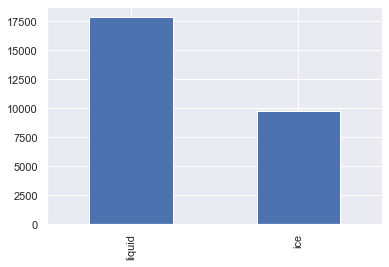

In [72]:
sub_df['label 2'].value_counts().plot(kind='bar')

plt.show()

In [73]:
train_db = sub_df.sample(frac=0.8, random_state=42)

test_db = sub_df.drop(train_db.index)

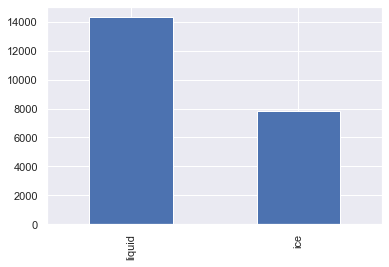

In [74]:
train_db['label 2'].value_counts().plot(kind='bar')

plt.show()

In [75]:
print( len( train_db[ train_db['label 2'] == 'liquid' ] ) )
print( len( train_db[ train_db['label 2'] != 'liquid' ] ) )

14294
7799


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a59226250>,
      dtype=object)

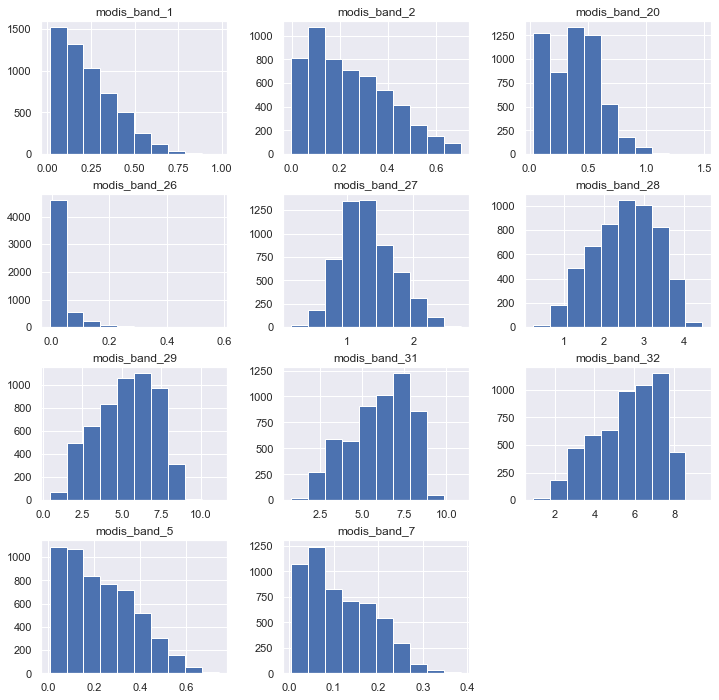

In [76]:
features_list = ['modis_band_1', 'modis_band_2', 'modis_band_5', 'modis_band_7', 'modis_band_20', 
                 'modis_band_26', 'modis_band_27', 'modis_band_28', 'modis_band_29', 'modis_band_31', 'modis_band_32']

test_db[ features_list ].hist(figsize=(12,12))

In [77]:
def data_preparation(features_list, train_dataset, test_dataset, label_name):

    #----- create labels -----#
    
    train_dataset_prepared = train_dataset.copy()

    test_dataset_prepared = test_dataset.copy()
    
    train_dataset_prepared = train_dataset_prepared[features_list + ['label 2']]

    test_dataset_prepared = test_dataset_prepared[features_list + ['label 2']]
        
    train_dataset_prepared['label 2'][ train_dataset_prepared['label 2'] != label_name ] = '(not) ' + label_name

    #----- upsampling -----#
    
    #if len(train_dataset_prepared[ train_dataset_prepared['label 2'] != label_name  ]) > len(train_dataset_prepared[ train_dataset_prepared['label 2'] == label_name  ]):
    #    t1 = train_dataset_prepared[ train_dataset_prepared['label 2'] == label_name  ]
    #    t2 = train_dataset_prepared[ train_dataset_prepared['label 2'] != label_name  ]
    #else:
    #    t1 = train_dataset_prepared[ train_dataset_prepared['label 2'] != label_name  ]
    #    t2 = train_dataset_prepared[ train_dataset_prepared['label 2'] == label_name  ]

    #ids = np.arange(len(t1))
    #choices = np.random.choice(ids, len(t2))

    #t1 = t1.iloc[choices,:]

    #train_dataset_prepared = pd.concat([t1, t2], axis=0)

    #----- labels encoding  -----#
    
    train_dataset_prepared_labels = train_dataset_prepared.pop('label 2')
    test_dataset_prepared_labels = test_dataset_prepared.pop('label 2')    

    train_dataset_prepared_labels[ train_dataset_prepared_labels != label_name] = 0.0
    train_dataset_prepared_labels[ train_dataset_prepared_labels == label_name] = 1.0

    test_dataset_prepared_labels[ test_dataset_prepared_labels != label_name] = 0.0
    test_dataset_prepared_labels[ test_dataset_prepared_labels == label_name] = 1.0

    #----- data scaling -----#

    train_dataset_prepared_stats = train_dataset_prepared.describe()
    train_dataset_prepared_stats = train_dataset_prepared_stats.transpose()

    def scaled_data(x):
      return (x - train_dataset_prepared_stats['mean']) / train_dataset_prepared_stats['std']    

    train_dataset_prepared = scaled_data(train_dataset_prepared)

    test_dataset_prepared = scaled_data(test_dataset_prepared)
    
    return train_dataset_prepared, train_dataset_prepared_labels, train_dataset_prepared_stats, test_dataset_prepared, test_dataset_prepared_labels, scaled_data

In [78]:
features_list = ['modis_band_1', 'modis_band_2', 'modis_band_5', 'modis_band_7', 'modis_band_20', 
                 'modis_band_26', 'modis_band_27', 'modis_band_28', 'modis_band_29', 'modis_band_31', 'modis_band_32']

#features_list = ['modis_band_1', 'modis_band_2', 'modis_band_5', 'modis_band_7', 'modis_band_20', 
#                 'modis_band_26', 'modis_band_29', 'modis_band_31', 'modis_band_32']

label_name = 'liquid'

train_x, train_y, liquid_train_x_stats, test_x, test_y, scaler  = data_preparation(features_list, 
                                                             train_db, 
                                                             test_db, 
                                                             label_name = label_name)  

#train_x, train_y, train_x_stats, test_x, test_y, scaler  = data_preparation(features_list, 
#                                                             train_db[ train_db['surface_flag'] == 0 ], 
#                                                             test_db[ test_db['surface_flag'] == 0 ], 
#                                                             label_name = label_name)  

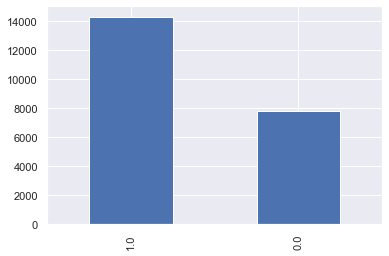

In [79]:
train_y.value_counts().plot(kind='bar')

plt.show() 

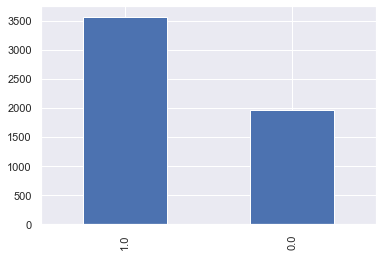

In [80]:
test_y.value_counts().plot(kind='bar')

plt.show() 

In [81]:
liquid_train_x_stats

,count,mean,std,min,25%,50%,75%,max
modis_band_1,22093.0,0.240878,0.163150,0.012437,0.104878,0.204293,0.344394,0.988717
modis_band_2,22093.0,0.248878,0.165990,-0.000226,0.106177,0.220495,0.366858,0.709580
modis_band_5,22093.0,0.233906,0.153208,0.007625,0.099972,0.212017,0.342498,0.827154
modis_band_7,22093.0,0.118850,0.075949,0.006146,0.053234,0.103723,0.176887,0.518695
modis_band_20,22093.0,0.389176,0.220582,0.025695,0.206033,0.395866,0.537046,1.648877
modis_band_26,22093.0,0.029843,0.057046,-0.007531,0.001520,0.007161,0.031614,0.647939
modis_band_27,22093.0,1.312721,0.405572,0.126172,1.031357,1.274209,1.571853,2.842788
modis_band_28,22093.0,2.532266,0.798988,0.184465,1.974248,2.594898,3.139531,4.689906
modis_band_29,22093.0,5.276847,1.864947,0.370453,3.956965,5.425441,6.792527,11.145588
modis_band_31,22093.0,5.992599,1.812146,0.724392,4.756143,6.214602,7.462199,11.191324


In [82]:
def build_model(input_dataset):
    model = keras.Sequential([
    layers.Dense(20, activation='relu', input_shape=[len(input_dataset.keys())]),
    layers.Dense(10, activation='relu'),
    layers.Dense(10, activation='relu'),
    layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

liquid_model = build_model(train_x)

liquid_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 20)                240       
_________________________________________________________________
dense_17 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_18 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


In [83]:
train_x

,modis_band_1,modis_band_2,modis_band_5,modis_band_7,modis_band_20,modis_band_26,modis_band_27,modis_band_28,modis_band_29,modis_band_31,modis_band_32
64500,-0.441017,-0.445911,-0.565280,0.239933,1.535364,-0.438069,1.661022,1.362450,0.965363,0.924459,0.923513
74492,-0.156753,0.118994,0.323356,-0.363816,-0.700508,1.837629,-1.479344,-1.573717,-0.973886,-1.153502,-1.236531
21177,0.439625,0.512328,0.333681,0.007373,-0.531466,-0.503922,0.010507,0.058397,-0.126734,-0.029047,0.034730
44434,-0.893007,-0.903577,-0.920041,-0.526319,-0.144996,-0.441775,0.956772,0.737642,0.239788,0.316442,0.288414
56117,0.169270,0.247465,0.264121,0.611288,-0.101008,-0.328064,0.849275,0.880717,0.427679,0.492778,0.555227
...,...,...,...,...,...,...,...,...,...,...,...
127838,-0.963463,-1.038914,-1.199542,-1.024915,0.567618,-0.513297,0.867287,1.306810,1.643741,1.638063,1.590898
74424,0.637876,0.743089,0.916914,1.116391,-0.385047,-0.341099,-0.469453,-0.387688,-0.544335,-0.430202,-0.375778
83914,-0.365516,-0.315524,-0.233353,0.359684,0.099140,-0.473620,0.089822,0.725117,0.427081,0.488109,0.546002
115907,2.486875,2.420631,1.739391,0.307876,-0.401700,-0.314200,0.722312,0.235435,-0.317911,-0.244529,-0.203343


In [84]:
train_x.keys()

Index(['modis_band_1', 'modis_band_2', 'modis_band_5', 'modis_band_7',
       'modis_band_20', 'modis_band_26', 'modis_band_27', 'modis_band_28',
       'modis_band_29', 'modis_band_31', 'modis_band_32'],
      dtype='object')

In [85]:
input_shape=[len(train_x.keys())]

input_shape

[11]

In [86]:
train_y

64500     1
74492     0
21177     1
44434     1
56117     1
         ..
127838    1
74424     1
83914     1
115907    1
15997     1
Name: label 2, Length: 22093, dtype: object

In [87]:
liquid_model.fit(train_x, train_y, epochs=600, batch_size=400, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.5800,  loss:0.6546,  
....................................................................................................
Epoch: 100, accuracy:0.9085,  loss:0.2677,  
....................................................................................................
Epoch: 200, accuracy:0.9111,  loss:0.2621,  
....................................................................................................
Epoch: 300, accuracy:0.9122,  loss:0.2584,  
....................................................................................................
Epoch: 400, accuracy:0.9132,  loss:0.2549,  
....................................................................................................
Epoch: 500, accuracy:0.9141,  loss:0.2532,  
....................................................................................................

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a4bc45dd0>,
      dtype=object)

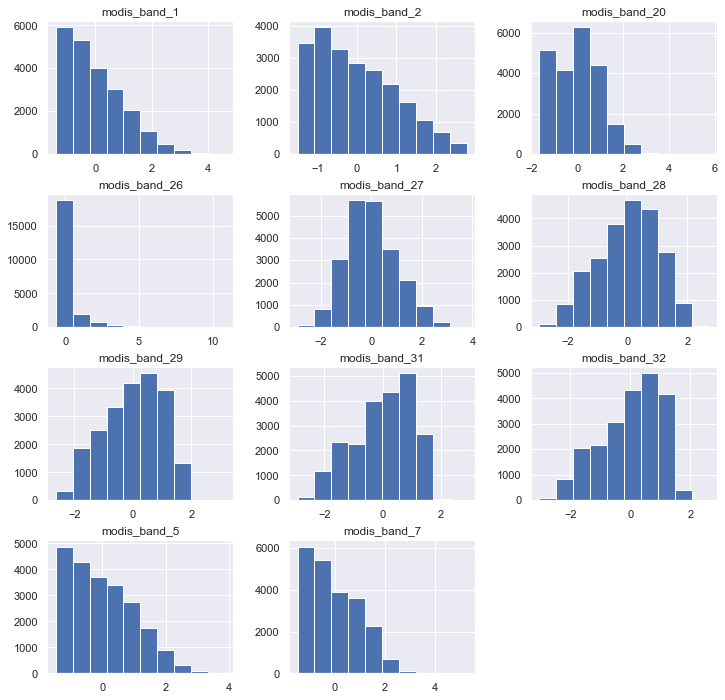

In [88]:
train_x.hist(figsize=(12,12))

In [89]:
tmp_train_x = train_x.describe()
tmp_train_x = tmp_train_x.transpose()

tmp_train_x

,count,mean,std,min,25%,50%,75%,max
modis_band_1,22093.0,2.830207e-17,1.0,-1.400192,-0.833592,-0.224244,0.634482,4.583759
modis_band_2,22093.0,2.605077e-17,1.0,-1.500721,-0.859700,-0.170992,0.710769,2.775483
modis_band_5,22093.0,-2.058332e-17,1.0,-1.476956,-0.874196,-0.142869,0.708795,3.872190
modis_band_7,22093.0,1.286458e-17,1.0,-1.483952,-0.863952,-0.199173,0.764150,5.264652
modis_band_20,22093.0,-1.260729e-16,1.0,-1.647831,-0.830274,0.030330,0.670362,5.710815
modis_band_26,22093.0,3.473436e-17,1.0,-0.655163,-0.496506,-0.397623,0.031036,10.835037
modis_band_27,22093.0,-3.129308e-16,1.0,-2.925615,-0.693744,-0.094956,0.638929,3.772613
modis_band_28,22093.0,-2.605077e-17,1.0,-2.938468,-0.698406,0.078389,0.760042,2.700466
modis_band_29,22093.0,-6.432288e-17,1.0,-2.630850,-0.707732,0.079677,0.812720,3.146868
modis_band_31,22093.0,3.569920e-17,1.0,-2.907164,-0.682316,0.122508,0.810972,2.868823


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a53a2b650>,
      dtype=object)

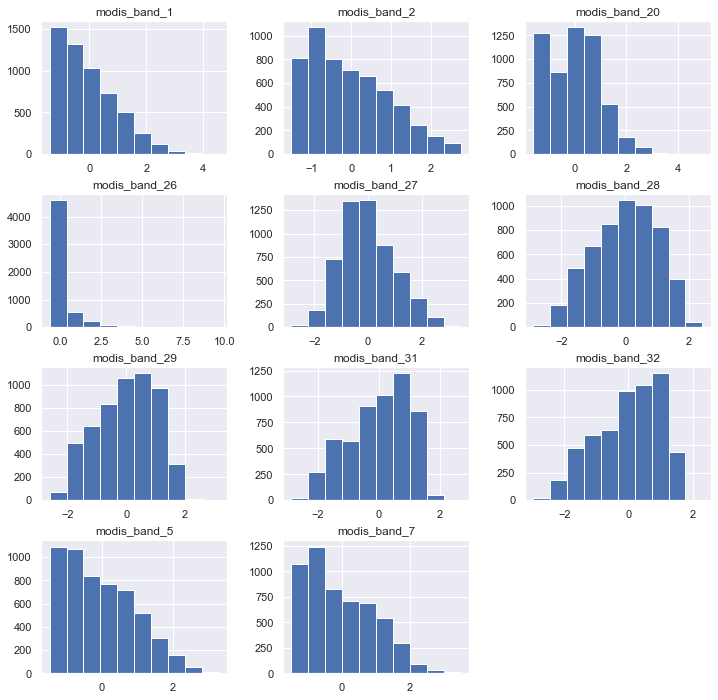

In [90]:
test_x.hist(figsize=(12,12))

In [91]:
yhat = liquid_model.predict(test_x)

In [92]:
ytrue  = test_y.to_numpy()
ytrue = ytrue.reshape(-1,1)

In [93]:
m = tf.keras.metrics.AUC(num_thresholds=200)

m.update_state(list(ytrue), list(yhat))

m.result().numpy()

0.94053894

In [94]:
def plot_modis_granule_dl_model_prediction_function(data, title,output_file_name):
    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    cmap = [(0.0,0.0,0.0)] + [(cm.RdBu_r(i)) for i in range(1,256)] 
    cmap = mpl.colors.ListedColormap(cmap)    
    img = plt.imshow(np.fliplr(data), cmap=cmap,interpolation='none', origin='lower', vmin=0.0, vmax=1.0)
    cbar = plt.colorbar(img, cmap=cmap)
    plt.title(title, fontsize=11)
    l = [int(i) for i in np.linspace(0,data.shape[1],6)]
    plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )
    l = [int(i) for i in np.linspace(0,data.shape[0],9)]
    plt.yticks(l, l, rotation=0, fontsize=11 )
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.savefig(output_file_name, bbox_inches='tight')
    plt.show()   

In [95]:
def modis_l1_cloud_mask_vectorization(features_train, modis_band_dic, cloud_mask_flag):
    X_list = []
    for feature in features_train:
        modis_band = feature.replace('modis_band_','')  
        modis_band_idx = modis_band_dic[modis_band][1]
        
        #print(feature,modis_band,modis_band_idx)
        
        if modis_band_dic[modis_band][0].info()[0] == 'EV_250_Aggr1km_RefSB':
            data_band = modis_band_dic['EV_250_Aggr1km_RefSB_data'][modis_band_idx,:,:]
            data_band = (data_band - modis_band_dic['EV_250_Aggr1km_RefSB_offsets'][modis_band_idx]) * modis_band_dic['EV_250_Aggr1km_RefSB_scales'][modis_band_idx]
        
        if modis_band_dic[modis_band][0].info()[0] == 'EV_500_Aggr1km_RefSB':
            data_band = modis_band_dic['EV_500_Aggr1km_RefSB_data'][modis_band_idx,:,:]
            data_band = (data_band - modis_band_dic['EV_500_Aggr1km_RefSB_offsets'][modis_band_idx]) * modis_band_dic['EV_500_Aggr1km_RefSB_scales'][modis_band_idx]
        
        if modis_band_dic[modis_band][0].info()[0] == 'EV_1KM_RefSB':
            data_band = modis_band_dic['EV_1KM_RefSB_data'][modis_band_idx,:,:]
            data_band = (data_band - modis_band_dic['EV_1KM_RefSB_offsets'][modis_band_idx]) * modis_band_dic['EV_1KM_RefSB_scales'][modis_band_idx]
        
        if modis_band_dic[modis_band][0].info()[0] == 'EV_1KM_Emissive':
            data_band = modis_band_dic['EV_1KM_Emissive_data'][modis_band_idx,:,:] 
            data_band = (data_band - modis_band_dic['EV_1KM_Emissive_offsets'][modis_band_idx]) * modis_band_dic['EV_1KM_Emissive_scales'][modis_band_idx]
        
        X_list.append( select_cloudy_pixel_only(data_band, cloud_mask_flag) )
    return np.stack(X_list, axis=-1)  

In [96]:
def bits_stripping(bit_start,bit_count,value):
    bitmask=pow(2,bit_start+bit_count)-1
    return np.right_shift(np.bitwise_and(value,bitmask),bit_start)

In [97]:
def select_cloudy_pixel_only(data, cloud_mask_flag):
    data_masked = ma.masked_where( cloud_mask_flag > 1, data)
    return np.ma.compressed(data_masked)    

In [98]:
def modis_granule_dl_model_prediction_function(myd021km_file_name, myd06_file_name, model, features_list, train_x_stats):
    
    tmp = myd021km_file_name.split('.')
        
    myd021km_file = SD(myd021km_file_name, SDC.READ)
    myd06_file = SD(myd06_file_name, SDC.READ)

    #
    # Get Modis Cloud Mask
    #     
    
    data_selected_id = myd06_file.select('Cloud_Mask_1km')
    data = data_selected_id.get()   
    cloud_mask_flag = bits_stripping(1,2,data[:,:,0])

    #
    # Get Modis L1
    #    
    
    EV_250_Aggr1km_RefSB = myd021km_file.select('EV_250_Aggr1km_RefSB')
    EV_500_Aggr1km_RefSB = myd021km_file.select('EV_500_Aggr1km_RefSB')
    EV_1KM_RefSB = myd021km_file.select('EV_1KM_RefSB')
    EV_1KM_Emissive = myd021km_file.select('EV_1KM_Emissive')

    modis_band_dic = {}

    EV_250_Aggr1km_RefSB_attributes = EV_250_Aggr1km_RefSB.attributes()
    EV_250_Aggr1km_RefSB_scales = EV_250_Aggr1km_RefSB_attributes['reflectance_scales']
    EV_250_Aggr1km_RefSB_offsets = EV_250_Aggr1km_RefSB_attributes['reflectance_offsets']
    modis_band_dic['EV_250_Aggr1km_RefSB_scales'] = EV_250_Aggr1km_RefSB_attributes['reflectance_scales']
    modis_band_dic['EV_250_Aggr1km_RefSB_offsets'] = EV_250_Aggr1km_RefSB_attributes['reflectance_offsets']
    
    for idx,i in enumerate(EV_250_Aggr1km_RefSB_attributes['band_names'].split(',')):
        modis_band_dic[i] = [EV_250_Aggr1km_RefSB,idx]    
    
    EV_500_Aggr1km_RefSB_attributes = EV_500_Aggr1km_RefSB.attributes()
    EV_500_Aggr1km_RefSB_scales = EV_500_Aggr1km_RefSB_attributes['reflectance_scales']
    EV_500_Aggr1km_RefSB_offsets = EV_500_Aggr1km_RefSB_attributes['reflectance_offsets']
    modis_band_dic['EV_500_Aggr1km_RefSB_scales'] = EV_500_Aggr1km_RefSB_attributes['reflectance_scales']
    modis_band_dic['EV_500_Aggr1km_RefSB_offsets'] = EV_500_Aggr1km_RefSB_attributes['reflectance_offsets']
    
    for idx,i in enumerate(EV_500_Aggr1km_RefSB_attributes['band_names'].split(',')):
        modis_band_dic[i] = [EV_500_Aggr1km_RefSB,idx]

    EV_1KM_RefSB_attributes = EV_1KM_RefSB.attributes()
    EV_1KM_RefSB_scales = EV_1KM_RefSB_attributes['reflectance_scales']
    EV_1KM_RefSB_offsets = EV_1KM_RefSB_attributes['reflectance_offsets']
    modis_band_dic['EV_1KM_RefSB_scales'] = EV_1KM_RefSB_attributes['reflectance_scales']
    modis_band_dic['EV_1KM_RefSB_offsets'] = EV_1KM_RefSB_attributes['reflectance_offsets']
    
    for idx,i in enumerate(EV_1KM_RefSB_attributes['band_names'].split(',')):
        modis_band_dic[i] = [EV_1KM_RefSB,idx]

    EV_1KM_Emissive_attributes = EV_1KM_Emissive.attributes()
    EV_1KM_Emissive_scales = EV_1KM_Emissive_attributes['radiance_scales']
    EV_1KM_Emissive_offsets = EV_1KM_Emissive_attributes['radiance_offsets']
    modis_band_dic['EV_1KM_Emissive_scales'] = EV_1KM_Emissive_attributes['radiance_scales']
    modis_band_dic['EV_1KM_Emissive_offsets'] = EV_1KM_Emissive_attributes['radiance_offsets']
 
    #
    # Modis Bands dictionary
    #

    for idx,i in enumerate(EV_1KM_Emissive_attributes['band_names'].split(',')):
        modis_band_dic[i] = [EV_1KM_Emissive,idx]
    
    #
    # Vectorization
    #
    
    A = np.argwhere( cloud_mask_flag < 2 ) # cloudy pixels
    row = A[:,0]
    col = A[:,1]

    EV_250_Aggr1km_RefSB_data = EV_250_Aggr1km_RefSB.get()
    EV_500_Aggr1km_RefSB_data = EV_500_Aggr1km_RefSB.get()
    EV_1KM_RefSB_data = EV_1KM_RefSB.get()
    EV_1KM_Emissive_data = EV_1KM_Emissive.get()
    
    modis_band_dic['EV_250_Aggr1km_RefSB_data'] = EV_250_Aggr1km_RefSB.get()
    modis_band_dic['EV_500_Aggr1km_RefSB_data'] = EV_500_Aggr1km_RefSB.get()
    modis_band_dic['EV_1KM_RefSB_data'] = EV_1KM_RefSB.get()
    modis_band_dic['EV_1KM_Emissive_data'] = EV_1KM_Emissive.get()
    
    #print(modis_band_dic)
    
    X = modis_l1_cloud_mask_vectorization(features_list, modis_band_dic, cloud_mask_flag)

    X = pd.DataFrame(data=X, columns=features_list)
    
    X_scaled = (X - train_x_stats['mean']) / train_x_stats['std'] 
    
    #print(X)
    
    #X.hist(figsize=(12,12))
    
    model_pred = model.predict(np.asarray(X_scaled))

    modis_y_prob = np.zeros((cloud_mask_flag.shape)) 
    modis_y_prob[row,col] = model_pred[:,0]
    
    return modis_y_prob

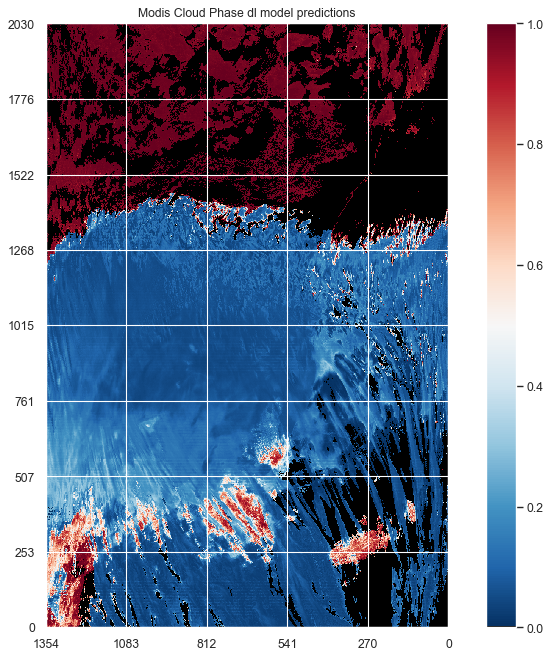

In [99]:
myd021km_file_name = './inputs/MYD021KM.A2008015.1435.006.2012066180438.hdf'
myd06_file_name = './inputs/MYD06_L2.A2008015.1435.006.2013342100940.hdf'

modis_y_prob = modis_granule_dl_model_prediction_function(myd021km_file_name, myd06_file_name, liquid_model, features_list, liquid_train_x_stats)

output_file_name = 'modis_cloud_phase_dl_predictions.png'

plot_modis_granule_dl_model_prediction_function(modis_y_prob, 'Modis Cloud Phase dl model predictions',output_file_name)  

[[0.9737176 ]
 [0.06314006]
 [0.9860465 ]
 ...
 [0.9550028 ]
 [0.93591875]
 [0.09504887]]
<class 'numpy.ndarray'>
[[1.0]
 [0.0]
 [1.0]
 ...
 [1.0]
 [1.0]
 [0.0]]
<class 'numpy.ndarray'>
(5523, 1)
[[0.9737175703048706 1.0]
 [0.06314006447792053 0.0]
 [0.9860464930534363 1.0]
 ...
 [0.9550027847290039 1.0]
 [0.9359187483787537 1.0]
 [0.09504886716604233 0.0]]
           yhat ytrue
0      0.973718     1
1     0.0631401     0
2      0.986046     1
3      0.978311     1
4     0.0703398     0
...         ...   ...
5518   0.970232     1
5519  0.0278012     0
5520   0.955003     1
5521   0.935919     1
5522  0.0950489     0

[5523 rows x 2 columns]


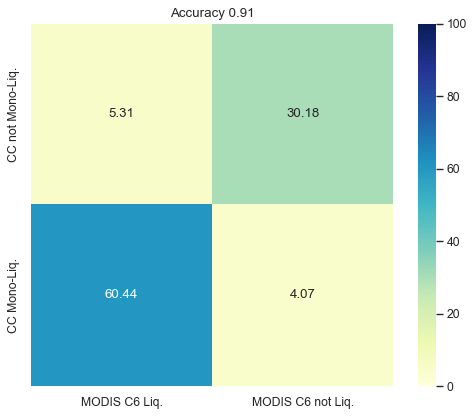

In [100]:
yhat = liquid_model.predict(test_x)

ytrue  = test_y.to_numpy()
ytrue = ytrue.reshape(-1,1)

print(yhat)
print(type(yhat))

print(ytrue)
print(type(ytrue))

print(yhat.shape)

print( np.hstack((yhat,ytrue)) )

data_cm = np.hstack((yhat,ytrue))

df_cm = pd.DataFrame(data_cm,columns=['yhat', 'ytrue'])

print(df_cm)

threshold = 0.5

c1 = df_cm[ (df_cm['ytrue'] == 1) & (df_cm['yhat'] > threshold)].shape[0]
c2 = df_cm[ (df_cm['ytrue'] == 1) & (df_cm['yhat'] <= threshold)].shape[0]
c3 = df_cm[ (df_cm['ytrue'] != 1) & (df_cm['yhat'] > threshold)].shape[0]
c4 = df_cm[ (df_cm['ytrue'] != 1) & (df_cm['yhat'] <= threshold)].shape[0]

tot_counts = df_cm.shape[0]

conf_arr = np.array([[ c3,   c4],
                     [  c1,  c2]])

conf_arr = 100. * conf_arr / tot_counts

df_cm = pd.DataFrame(conf_arr, 
                  index = ['CC Mono-Liq.', 'CC not Mono-Liq.'],
                  columns = ['MODIS C6 Liq.', 'MODIS C6 not Liq.'])

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.clf()

ax = fig.add_subplot(111)

ax.set_aspect(1)

res = sn.heatmap(df_cm, annot=True, vmin=0.0, vmax=100.0, fmt='.2f', cmap="YlGnBu")

plt.yticks([1.5,0.5], ['CC Mono-Liq.', 'CC not Mono-Liq.'],va='center')

plt.title('Accuracy '+str(round((c1+c4)/tot_counts,2)))

plt.show()

In [101]:
vir_2_features_list = ['modis_band_1', 'modis_band_2', 'modis_band_5', 
                       'modis_band_6', 'modis_band_7', 'modis_band_20', 
                       'modis_band_29', 'modis_band_31', 'modis_band_32']

label_name = 'liquid'

train_x, train_y, vir_2_model_train_x_stats, test_x, test_y, scaler  = data_preparation(features_list, 
                                                                                        train_db, 
                                                                                        test_db, 
                                                                                        label_name = label_name)  

In [102]:
vir_2_model = build_model(train_x)

In [103]:
vir_2_model.fit(train_x, train_y, epochs=600, batch_size=400, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.6848,  loss:0.6005,  
....................................................................................................
Epoch: 100, accuracy:0.9084,  loss:0.2667,  
....................................................................................................
Epoch: 200, accuracy:0.9106,  loss:0.2607,  
....................................................................................................
Epoch: 300, accuracy:0.9115,  loss:0.2566,  
....................................................................................................
Epoch: 400, accuracy:0.9116,  loss:0.2560,  
....................................................................................................
Epoch: 500, accuracy:0.9133,  loss:0.2530,  
....................................................................................................

In [104]:
yhat = vir_2_model.predict(test_x)

ytrue  = test_y.to_numpy()
ytrue = ytrue.reshape(-1,1)

m = tf.keras.metrics.AUC(num_thresholds=200)

m.update_state(list(ytrue), list(yhat))

m.result().numpy()

0.93946415

In [134]:
features_list = ['modis_band_28', 'modis_band_29', 'modis_band_31', 'modis_band_32']

label_name = 'liquid'

train_x, train_y, ir_model_train_x_stats, test_x, test_y, scaler  = data_preparation(features_list, 
                                                                                     train_db, 
                                                                                     test_db, 
                                                                                     label_name = label_name)  

In [106]:
ir_model = build_model(train_x)

In [107]:
ir_model.fit(train_x, train_y, epochs=600, batch_size=400, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.7687,  loss:0.6153,  
....................................................................................................
Epoch: 100, accuracy:0.8850,  loss:0.3159,  
....................................................................................................
Epoch: 200, accuracy:0.8859,  loss:0.3133,  
....................................................................................................
Epoch: 300, accuracy:0.8866,  loss:0.3122,  
....................................................................................................
Epoch: 400, accuracy:0.8868,  loss:0.3106,  
....................................................................................................
Epoch: 500, accuracy:0.8873,  loss:0.3101,  
....................................................................................................

In [108]:
yhat = ir_model.predict(test_x)

ytrue  = test_y.to_numpy()
ytrue = ytrue.reshape(-1,1)

m = tf.keras.metrics.AUC(num_thresholds=200)

m.update_state(list(ytrue), list(yhat))

m.result().numpy()

0.9244616

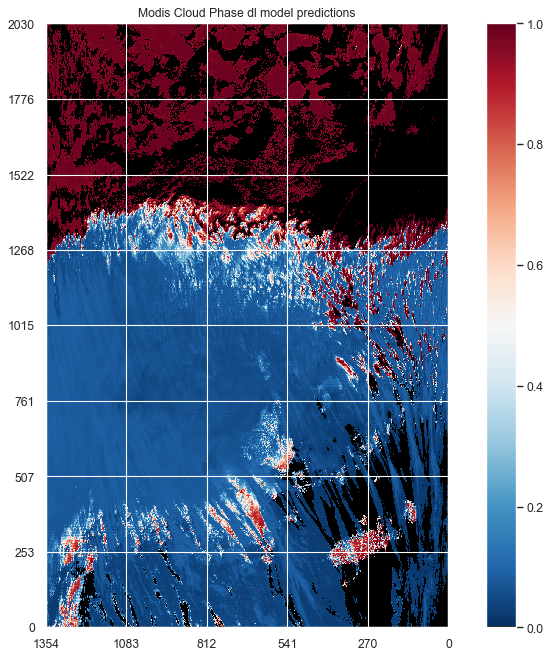

In [109]:
myd021km_file_name = './inputs/MYD021KM.A2008015.1435.006.2012066180438.hdf'
myd06_file_name = './inputs/MYD06_L2.A2008015.1435.006.2013342100940.hdf'

modis_y_prob = modis_granule_dl_model_prediction_function(myd021km_file_name, myd06_file_name, ir_model, features_list, ir_model_train_x_stats)

output_file_name = 'modis_cloud_phase_dl_predictions.png'

plot_modis_granule_dl_model_prediction_function(modis_y_prob, 'Modis Cloud Phase dl model predictions',output_file_name)  

In [135]:
features_list = ['modis_band_1', 'modis_band_2', 'modis_band_5', 'modis_band_7', 'modis_band_20']

label_name = 'liquid'

train_x, train_y, vis_swir_model_train_x_stats, test_x, test_y, scaler  = data_preparation(features_list, 
                                                                                     train_db, 
                                                                                     test_db, 
                                                                                     label_name = label_name)  

In [111]:
vis_swir_model = build_model(train_x)

In [112]:
vis_swir_model.fit(train_x, train_y, epochs=600, batch_size=400, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.7650,  loss:0.6041,  
....................................................................................................
Epoch: 100, accuracy:0.8795,  loss:0.3325,  
....................................................................................................
Epoch: 200, accuracy:0.8850,  loss:0.3213,  
....................................................................................................
Epoch: 300, accuracy:0.8887,  loss:0.3157,  
....................................................................................................
Epoch: 400, accuracy:0.8888,  loss:0.3132,  
....................................................................................................
Epoch: 500, accuracy:0.8897,  loss:0.3107,  
....................................................................................................

In [113]:
yhat = vis_swir_model.predict(test_x)

ytrue  = test_y.to_numpy()
ytrue = ytrue.reshape(-1,1)

m = tf.keras.metrics.AUC(num_thresholds=200)

m.update_state(list(ytrue), list(yhat))

m.result().numpy()

0.91226125

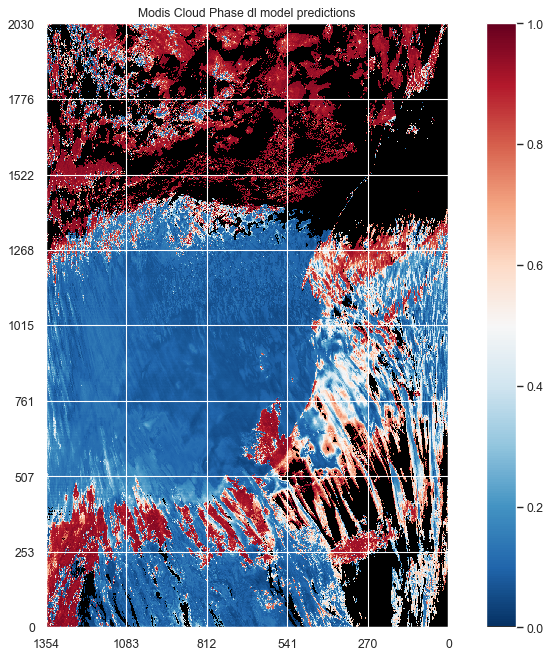

In [114]:
myd021km_file_name = './inputs/MYD021KM.A2008015.1435.006.2012066180438.hdf'
myd06_file_name = './inputs/MYD06_L2.A2008015.1435.006.2013342100940.hdf'

modis_y_prob = modis_granule_dl_model_prediction_function(myd021km_file_name, myd06_file_name, vis_swir_model, features_list, vis_swir_model_train_x_stats)

output_file_name = 'modis_cloud_phase_dl_predictions.png'

plot_modis_granule_dl_model_prediction_function(modis_y_prob, 'Modis Cloud Phase dl model predictions',output_file_name)  

In [150]:
with pd.HDFStore('inputs/random_sample_modis_caliop_cloudsat_{:04d}_{:02d}.hdf5'.format(year,month)) as store:
    print(store.keys())
    df_test = store['random_sample']

['/random_sample']


In [151]:
df_test = df_test.sample(n=10000, random_state = 42)

In [152]:
features_list = ['modis_band_1', 'modis_band_2', 'modis_band_5', 'modis_band_7', 'modis_band_20']

#test_db[features_list]

X_scaled = (df_test[features_list] - vis_swir_model_train_x_stats['mean']) / vis_swir_model_train_x_stats['std'] 

yhat_vis_swir = vis_swir_model.predict(X_scaled)

In [153]:
features_list = ['modis_band_28', 'modis_band_29', 'modis_band_31', 'modis_band_32']

#test_db[features_list]

X_scaled = (df_test[features_list] - ir_model_train_x_stats['mean']) / ir_model_train_x_stats['std'] 

yhat_ir = ir_model.predict(X_scaled)

In [154]:
test_db_tmp = df_test.copy()

test_db_tmp['yhat_vis_swir'] = yhat_vis_swir
test_db_tmp['yhat_ir'] = yhat_ir

In [155]:
test_db_tmp[['label 2','yhat_vis_swir','yhat_ir']]

,label 2,yhat_vis_swir,yhat_ir
82899,mixed,0.881056,0.175515
35211,liquid,0.946064,0.967670
33438,ice / ice,0.619582,0.786659
7025,liquid / liquid,0.894662,0.922336
120921,unlabeled,0.880050,0.373620
...,...,...,...
110615,ice / mixed,0.138169,0.088345
123195,liquid,0.916754,0.893555
137743,ice / mixed,0.016203,0.083135
47924,ice / ice,0.107416,0.095287


In [156]:
test_db_tmp[ test_db_tmp['label 2'] == 'ice / liquid' ]

,modis_multilayer_cloud,modis_multilayer_cloud_qa1,modis_multilayer_cloud_qa2,modis_multilayer_cloud_qa3,modis_multilayer_cloud_qa4,modis_multilayer_cloud_qa5,modis_cloud_phase,latitude,longitude,modis_cloud_top_height_1km,...,cloud_layer_source_09,cloud_layer_top_10,cloud_layer_base_10,cloud_layer_optical_depth_10,cloud_layer_phase_10,cloud_layer_source_10,label 1,label 2,yhat_vis_swir,yhat_ir
73268,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-8.065061,-10.787115,700.0,...,0.0,0.0,0.0,-9999.0,0.0,0.0,multilayer (n=2),ice / liquid,0.928095,0.912751
34512,1.0,0.0,0.0,0.0,0.0,0.0,2.0,35.493103,-8.473916,2050.0,...,0.0,0.0,0.0,-9999.0,0.0,0.0,multilayer (n=2),ice / liquid,0.948059,0.947443
659,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-47.396938,-120.729767,1500.0,...,0.0,0.0,0.0,-9999.0,0.0,0.0,multilayer (n=2),ice / liquid,0.958393,0.943413
32399,2.0,1.0,0.0,0.0,0.0,0.0,2.0,-64.996681,-2.365263,4200.0,...,0.0,0.0,0.0,-9999.0,0.0,0.0,multilayer (n=2),ice / liquid,0.383955,0.244025
146500,1.0,0.0,0.0,0.0,0.0,0.0,2.0,3.127401,-125.980438,250.0,...,0.0,0.0,0.0,-9999.0,0.0,0.0,multilayer (n=2),ice / liquid,0.896670,0.926912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119673,6.0,0.0,0.0,1.0,0.0,1.0,3.0,37.793835,153.061127,8650.0,...,0.0,0.0,0.0,-9999.0,0.0,0.0,multilayer (n=2),ice / liquid,0.112853,0.073670
9164,1.0,0.0,0.0,0.0,0.0,0.0,2.0,-51.016621,18.268307,800.0,...,0.0,0.0,0.0,-9999.0,0.0,0.0,multilayer (n=2),ice / liquid,0.836509,0.877198
40384,4.0,0.0,0.0,0.0,0.0,1.0,3.0,28.628887,-52.964577,10700.0,...,0.0,0.0,0.0,-9999.0,0.0,0.0,multilayer (n=2),ice / liquid,0.100967,0.085057
130880,1.0,0.0,0.0,0.0,0.0,0.0,2.0,1.032541,79.961723,950.0,...,0.0,0.0,0.0,-9999.0,0.0,0.0,multilayer (n=2),ice / liquid,0.746995,0.219200


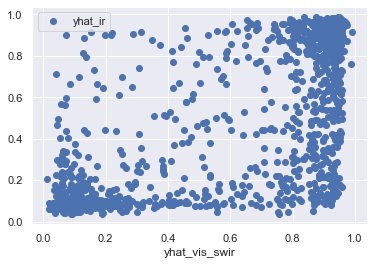

In [158]:
#test_db_tmp[ test_db_tmp['label 2'] == 'ice / liquid' ][['yhat_vis_swir','yhat_ir']].plot(style=['o','rx'])
test_db_tmp[ test_db_tmp['label 2'] == 'ice / liquid' ].plot(x='yhat_vis_swir', y='yhat_ir', style='o')

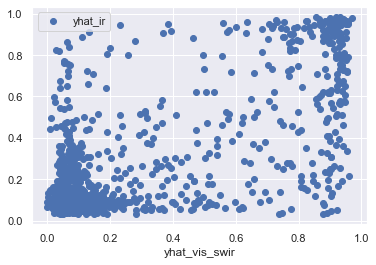

In [160]:
test_db_tmp[ test_db_tmp['label 2'] == 'ice' ].plot(x='yhat_vis_swir', y='yhat_ir', style='o')

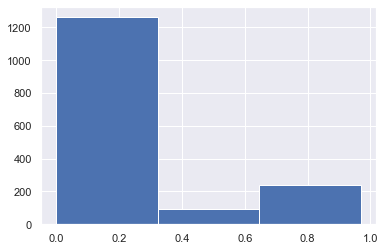

In [161]:
hist = test_db_tmp[ test_db_tmp['label 2'] == 'ice' ]['yhat_vis_swir'].hist(bins=3)

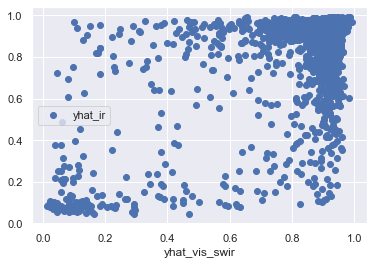

In [159]:
test_db_tmp[ test_db_tmp['label 2'] == 'liquid' ].plot(x='yhat_vis_swir', y='yhat_ir', style='o')

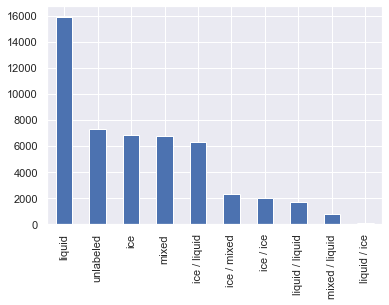

In [115]:
df['label 2'][ df['surface_flag'] == 0 ].value_counts().plot(kind='bar')

plt.show()

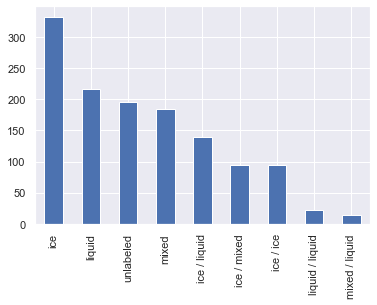

In [116]:
df['label 2'][ df['surface_flag'] == 1 ].value_counts().plot(kind='bar')

plt.show()

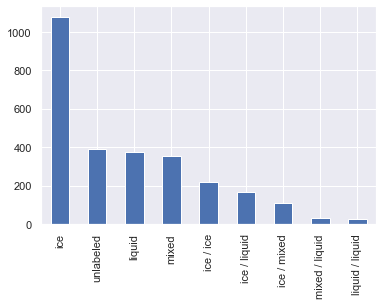

In [117]:
df['label 2'][ df['surface_flag'] == 2 ].value_counts().plot(kind='bar')

plt.show()

In [118]:
train_db = sub_df.sample(frac=0.8, random_state=42)

test_db = sub_df.drop(train_db.index)

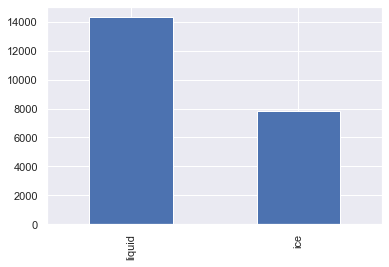

In [119]:
train_db['label 2'].value_counts().plot(kind='bar')

plt.show()

In [120]:
features_list = ['modis_band_1', 'modis_band_2', 'modis_band_5', 'modis_band_7', 'modis_band_20', 
                 'modis_band_26', 'modis_band_27', 'modis_band_28', 'modis_band_29', 'modis_band_31', 'modis_band_32']

#features_list = ['modis_band_1', 'modis_band_2', 'modis_band_5', 'modis_band_7', 'modis_band_20', 
#                 'modis_band_26', 'modis_band_29', 'modis_band_31', 'modis_band_32']

label_name = 'ice'

train_x, train_y, ice_train_x_stats, test_x, test_y, scaler  = data_preparation(features_list, 
                                                             train_db, 
                                                             test_db, 
                                                             label_name = label_name) 

#train_x, train_y, train_x_stats, test_x, test_y, scaler  = data_preparation(features_list, 
#                                                             train_db[ train_db['surface_flag'] == 0 ], 
#                                                             test_db[ test_db['surface_flag'] == 0 ], 
#                                                             label_name = label_name) 

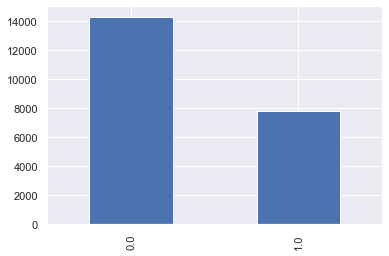

In [121]:
train_y.value_counts().plot(kind='bar')

plt.show() 

In [122]:
ice_model = build_model(train_x)

ice_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 20)                240       
_________________________________________________________________
dense_33 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_34 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 11        
Total params: 571
Trainable params: 571
Non-trainable params: 0
_________________________________________________________________


In [123]:
ice_model.fit(train_x, train_y, epochs=600, batch_size=400, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, accuracy:0.7145,  loss:0.6040,  
....................................................................................................
Epoch: 100, accuracy:0.9086,  loss:0.2654,  
....................................................................................................
Epoch: 200, accuracy:0.9111,  loss:0.2592,  
....................................................................................................
Epoch: 300, accuracy:0.9123,  loss:0.2558,  
....................................................................................................
Epoch: 400, accuracy:0.9137,  loss:0.2538,  
....................................................................................................
Epoch: 500, accuracy:0.9145,  loss:0.2508,  
....................................................................................................

In [124]:
yhat = ice_model.predict(test_x)

In [125]:
ytrue  = test_y.to_numpy()
ytrue = ytrue.reshape(-1,1)

In [126]:
m = tf.keras.metrics.AUC(num_thresholds=200)

m.update_state(list(ytrue), list(yhat))

m.result().numpy()

0.9399019

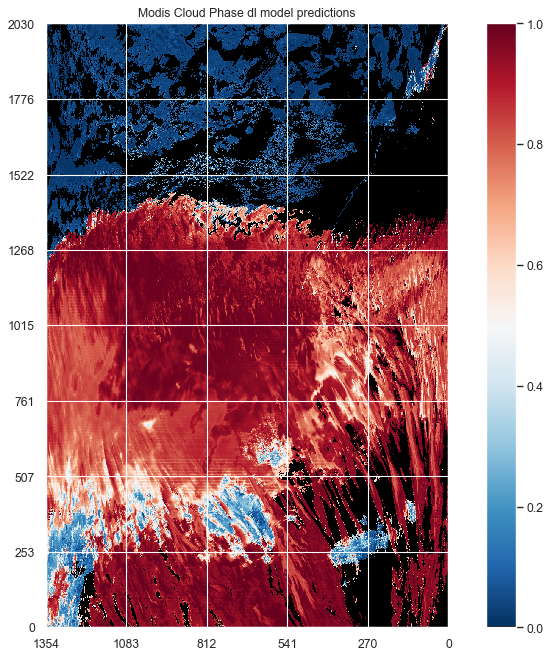

CPU times: user 1min 37s, sys: 14.9 s, total: 1min 52s
Wall time: 1min 6s


In [127]:
%%time

myd021km_file_name = './inputs/MYD021KM.A2008015.1435.006.2012066180438.hdf'
myd06_file_name = './inputs/MYD06_L2.A2008015.1435.006.2013342100940.hdf'

modis_y_prob = modis_granule_dl_model_prediction_function(myd021km_file_name, myd06_file_name, ice_model, features_list, ice_train_x_stats)

output_file_name = 'modis_cloud_phase_dl_predictions.png'

plot_modis_granule_dl_model_prediction_function(modis_y_prob, 'Modis Cloud Phase dl model predictions',output_file_name)  

In [128]:
modis_y_prob.shape

(2030, 1354)

In [129]:
modis_y_prob_to_int = np.copy(modis_y_prob)
modis_y_prob_to_int = modis_y_prob_to_int * 100.0

modis_y_prob_to_int = modis_y_prob_to_int.astype(int)

modis_y_prob_to_int

array([[ 0,  0,  0, ..., 51, 12, 14],
       [ 0,  0,  0, ..., 47, 10, 28],
       [ 0,  0,  0, ..., 40, 31, 50],
       ...,
       [ 0,  0,  0, ...,  1,  1,  1],
       [ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0,  1]])

In [130]:
f1 = h5py.File("./outputs/CPOP_ICE_DL.hdf5", "w")

dset1 = f1.create_dataset("CPOP", modis_y_prob_to_int.shape, dtype='i', data=modis_y_prob_to_int)

dset1.attrs['scale'] = 0.01

f1.close()

['CPOP']
[[ 0  0  0 ... 51 12 14]
 [ 0  0  0 ... 47 10 28]
 [ 0  0  0 ... 40 31 50]
 ...
 [ 0  0  0 ...  1  1  1]
 [ 0  0  0 ...  0  0  1]
 [ 0  0  0 ...  0  0  1]]
[]


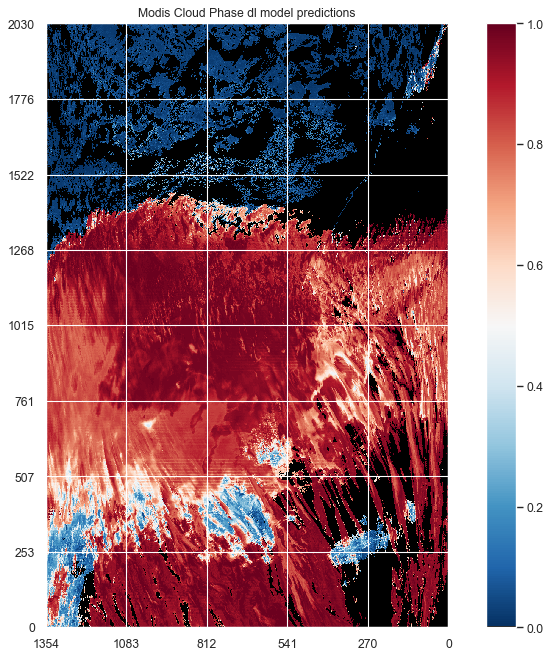

In [131]:
f2 = h5py.File('./outputs/CPOP_ICE_DL.hdf5', 'r')

print( list(f2.keys()) )

dset1 = f2['CPOP']

data = dset1[:]

print(data)

print(data[data>99])

data = data * 0.01

plot_modis_granule_dl_model_prediction_function(data, 'Modis Cloud Phase dl model predictions','')  



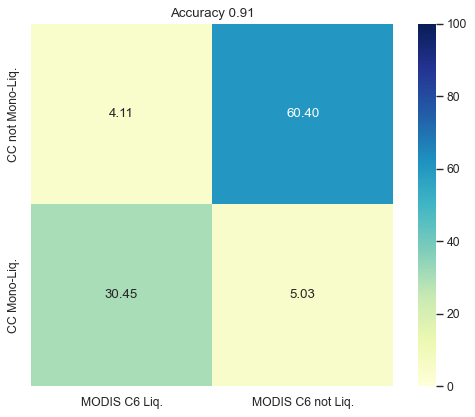

In [133]:
yhat = ice_model.predict(test_x)

ytrue  = test_y.to_numpy()
ytrue = ytrue.reshape(-1,1)

#print(yhat)
#print(type(yhat))

#print(ytrue)
#print(type(ytrue))

#print(yhat.shape)

#print( np.hstack((yhat,ytrue)) )

data_cm = np.hstack((yhat,ytrue))

df_cm = pd.DataFrame(data_cm,columns=['yhat', 'ytrue'])

#print(df_cm)

threshold = 0.5

c1 = df_cm[ (df_cm['ytrue'] == 1) & (df_cm['yhat'] > threshold)].shape[0]
c2 = df_cm[ (df_cm['ytrue'] == 1) & (df_cm['yhat'] <= threshold)].shape[0]
c3 = df_cm[ (df_cm['ytrue'] != 1) & (df_cm['yhat'] > threshold)].shape[0]
c4 = df_cm[ (df_cm['ytrue'] != 1) & (df_cm['yhat'] <= threshold)].shape[0]

tot_counts = df_cm.shape[0]

conf_arr = np.array([[ c3,   c4],
                     [  c1,  c2]])

conf_arr = 100. * conf_arr / tot_counts

df_cm = pd.DataFrame(conf_arr, 
                  index = ['CC Mono-Liq.', 'CC not Mono-Liq.'],
                  columns = ['MODIS C6 Liq.', 'MODIS C6 not Liq.'])

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.clf()

ax = fig.add_subplot(111)

ax.set_aspect(1)

res = sn.heatmap(df_cm, annot=True, vmin=0.0, vmax=100.0, fmt='.2f', cmap="YlGnBu")

plt.yticks([1.5,0.5], ['CC Mono-Liq.', 'CC not Mono-Liq.'],va='center')

plt.title('Accuracy '+str(round((c1+c4)/tot_counts,2)))

plt.show()

In [278]:
year = 2014
month = 2
day = 1

In [279]:
d0 = date(year, 1, 1)
d1 = date(year, month, day)
delta = d1 - d0

count_of_day = delta.days + 1

print(count_of_day)

32


In [280]:
path_to_media = '/Volumes/HD1/media/'

In [262]:
os.system( 'mkdir {}MODIS'.format(path_to_media) )
os.system( 'mkdir {}MODIS/MYD021KM'.format(path_to_media))
os.system( 'mkdir {}MODIS/MYD021KM/{:04d}'.format(path_to_media,year) )
os.system( 'mkdir {}MODIS/MYD021KM/{:04d}/{:04d}_{:02d}_{:02d}'.format(path_to_media,year,year,month,day) )

256

In [263]:
%%time

ladsweb_url = 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MYD021KM/{:04d}/{:03d}.json'.format(year,count_of_day)

with urllib.request.urlopen(ladsweb_url) as url:
    data = json.loads(url.read().decode())

#pp = pprint.PrettyPrinter(indent=4)
#pp.pprint(data)

CPU times: user 19.7 ms, sys: 11.4 ms, total: 31.1 ms
Wall time: 10.4 s


In [264]:
%%time

for file in data:
    file_name = file['name']
    #print(file_name) 
    if not path.exists('{}MODIS/MYD021KM/{:04d}/{:04d}_{:02d}_{:02d}/{}'.format(path_to_media,year,year,month,day,file_name)):
        try:
            ladsweb_url = 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MYD021KM/{:04d}/{:03d}/{}'.format(year,count_of_day,file_name)
            target_dir = '{}MODIS/MYD021KM/{:04d}/{:04d}_{:02d}_{:02d}/{}'.format(path_to_media,year,year,month,day,file_name)
            urllib.request.urlretrieve(ladsweb_url,target_dir) 
        except:
            pass

CPU times: user 2.39 ms, sys: 7 ms, total: 9.39 ms
Wall time: 117 ms


In [276]:
%%time

year = 2014
month = 2

for day in range(monthrange(year, month)[1]):
    
    day = day + 1
    
    if day == 27 or day == 28:
    
        d0 = date(year, 1, 1)
        d1 = date(year, month, day)
        delta = d1 - d0

        count_of_day = delta.days + 1

        os.system( 'mkdir {}MODIS/MYD021KM/{:04d}/{:04d}_{:02d}_{:02d}'.format(path_to_media,year,year,month,day) )

        ladsweb_url = 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MYD021KM/{:04d}/{:03d}.json'.format(year,count_of_day)

        with urllib.request.urlopen(ladsweb_url) as url:
            data = json.loads(url.read().decode())    

        for file in data:
            file_name = file['name']
            #print(file_name) 
            if not path.exists('{}MODIS/MYD021KM/{:04d}/{:04d}_{:02d}_{:02d}/{}'.format(path_to_media,year,year,month,day,file_name)):
                try:
                    ladsweb_url = 'https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MYD021KM/{:04d}/{:03d}/{}'.format(year,count_of_day,file_name)
                    target_dir = '{}MODIS/MYD021KM/{:04d}/{:04d}_{:02d}_{:02d}/{}'.format(path_to_media,year,year,month,day,file_name)
                    urllib.request.urlretrieve(ladsweb_url,target_dir) 
                except:
                    pass

    print('All files from day {} have been downloaded'.format(day))

All files from day 1 have been downloaded
All files from day 2 have been downloaded
All files from day 3 have been downloaded
All files from day 4 have been downloaded
All files from day 5 have been downloaded
All files from day 6 have been downloaded
All files from day 7 have been downloaded
All files from day 8 have been downloaded
All files from day 9 have been downloaded
All files from day 10 have been downloaded
All files from day 11 have been downloaded
All files from day 12 have been downloaded
All files from day 13 have been downloaded
All files from day 14 have been downloaded
All files from day 15 have been downloaded
All files from day 16 have been downloaded
All files from day 17 have been downloaded
All files from day 18 have been downloaded
All files from day 19 have been downloaded
All files from day 20 have been downloaded
All files from day 21 have been downloaded
All files from day 22 have been downloaded
All files from day 23 have been downloaded
All files from day 2

### Use deep learning models to predict cloud phase for a month<a class="anchor" id="one_month_prediction"></a>

In [306]:
os.system( 'mkdir {}MODIS/Deep_Learning'.format(path_to_media))
os.system( 'mkdir {}MODIS/Deep_Learning/CPOP'.format(path_to_media))
os.system( 'mkdir {}MODIS/Deep_Learning/IR_CPOP'.format(path_to_media))
os.system( 'mkdir {}MODIS/Deep_Learning/VIS_SWIR_CPOP'.format(path_to_media))

os.system( 'mkdir {}MODIS/Deep_Learning/CPOP/{:04d}'.format(path_to_media,year,year) )
os.system( 'mkdir {}MODIS/Deep_Learning/IR_CPOP/{:04d}'.format(path_to_media,year,year) )
os.system( 'mkdir {}MODIS/Deep_Learning/VIS_SWIR_CPOP/{:04d}'.format(path_to_media,year,year) )

0

In [267]:
liquid_train_x_stats

,count,mean,std,min,25%,50%,75%,max
modis_band_1,22093.0,0.240878,0.163150,0.012437,0.104878,0.204293,0.344394,0.988717
modis_band_2,22093.0,0.248878,0.165990,-0.000226,0.106177,0.220495,0.366858,0.709580
modis_band_5,22093.0,0.233906,0.153208,0.007625,0.099972,0.212017,0.342498,0.827154
modis_band_7,22093.0,0.118850,0.075949,0.006146,0.053234,0.103723,0.176887,0.518695
modis_band_20,22093.0,0.389176,0.220582,0.025695,0.206033,0.395866,0.537046,1.648877
modis_band_26,22093.0,0.029843,0.057046,-0.007531,0.001520,0.007161,0.031614,0.647939
modis_band_27,22093.0,1.312721,0.405572,0.126172,1.031357,1.274209,1.571853,2.842788
modis_band_28,22093.0,2.532266,0.798988,0.184465,1.974248,2.594898,3.139531,4.689906
modis_band_29,22093.0,5.276847,1.864947,0.370453,3.956965,5.425441,6.792527,11.145588
modis_band_31,22093.0,5.992599,1.812146,0.724392,4.756143,6.214602,7.462199,11.191324


In [307]:
%%time

path_to_media = '/Volumes/HD1/media/'

year = 2014
month = 2

for day in range(monthrange(year, month)[1]):

    if day == 1: 
        
        os.system( 'mkdir {}MODIS/Deep_Learning/CPOP/{:04d}/{:04d}_{:02d}_{:02d}'.format(path_to_media,year,year,month,day) )
        os.system( 'mkdir {}MODIS/Deep_Learning/IR_CPOP/{:04d}/{:04d}_{:02d}_{:02d}'.format(path_to_media,year,year,month,day) )
        os.system( 'mkdir {}MODIS/Deep_Learning/VIS_SWIR_CPOP/{:04d}/{:04d}_{:02d}_{:02d}'.format(path_to_media,year,year,month,day) )
        
        myd021km_list = glob.glob('{}MODIS/MYD021KM/{:04d}/{:04d}_{:02d}_{:02d}/*hdf'.format(path_to_media,year,year,month,day))
        myd06_list = glob.glob('{}MODIS/MYD06/{:04d}/{:04d}_{:02d}_{:02d}/*hdf'.format(path_to_media,year,year,month,day))
        
        for idx,myd06_path in enumerate(myd06_list):
        #for idx,myd06_path in enumerate(myd06_list[0:3]):

            myd06_name = myd06_path.split('/')[-1]

            myd21km_path = ''

            list_tmp = [i for i in myd021km_list if '{}.{}'.format(myd06_name.split('.')[1],myd06_name.split('.')[2]) in i]

            myd21km_path = list_tmp[0]
            
            #print('  ')
            
            if myd21km_path:

                file = SD(myd06_path, SDC.READ)

                sds_obj = file.select('Cloud_Mask_1km') 

                cloud_mask_data = sds_obj.get()

                day_flag = bits_stripping(3,1,cloud_mask_data[:,:,0]) 

                if day_flag.size == day_flag[ day_flag == 1].size: 
                    granule_day_flag = True
                else:
                    granule_day_flag = False

                if granule_day_flag:

                    #print(idx, myd06_name)
                    
                    #print(myd21km_path)
                    #print(myd06_path)
                    
                    output_file_name = "{}MODIS/Deep_Learning/CPOP/{:04d}/{:04d}_{:02d}_{:02d}/CPOP.MODIS.NN.T1.{}.{}.hdf5".format(path_to_media,year,year,month,day,myd06_name.split('.')[1],myd06_name.split('.')[2])
                                        
                    if not path.exists(output_file_name):
                                                
                        f1 = h5py.File(output_file_name, "w")
                        
                        #print(features_list)
                        
                        #print(liquid_train_x_stats)
                        
                        features_list = ['modis_band_1', 'modis_band_2', 'modis_band_5', 'modis_band_7', 'modis_band_20', 
                                         'modis_band_26', 'modis_band_27', 'modis_band_28', 'modis_band_29', 'modis_band_31', 'modis_band_32']
                        
                        modis_y_prob = modis_granule_dl_model_prediction_function(myd21km_path, myd06_path, liquid_model, features_list, liquid_train_x_stats)
                        
                        #print(modis_y_prob)
                        
                        modis_y_prob_to_int = np.copy(modis_y_prob)
                        modis_y_prob_to_int = modis_y_prob_to_int * 100.0
                        modis_y_prob_to_int = modis_y_prob_to_int.astype(int)

                        dset1 = f1.create_dataset("CPOP_liquid", modis_y_prob_to_int.shape, dtype='i', data=modis_y_prob_to_int)

                        dset1.attrs['scale'] = 0.01

                        dset2 = f1.create_dataset("CPOP_ice", modis_y_prob_to_int.shape, dtype='i', data= 100-modis_y_prob_to_int)

                        dset2.attrs['scale'] = 0.01                    

                        f1.close() 
                        
                    output_file_name = "{}MODIS/Deep_Learning/IR_CPOP/{:04d}/{:04d}_{:02d}_{:02d}/CPOP.MODIS.NN.T1.{}.{}.hdf5".format(path_to_media,year,year,month,day,myd06_name.split('.')[1],myd06_name.split('.')[2])
                                        
                    if not path.exists(output_file_name):
                                                
                        f1 = h5py.File(output_file_name, "w")
                        
                        #print(features_list)
                        
                        #print(liquid_train_x_stats)
                        
                        features_list = ['modis_band_28', 'modis_band_29', 'modis_band_31', 'modis_band_32']
                        
                        modis_y_prob = modis_granule_dl_model_prediction_function(myd21km_path, myd06_path, ir_model, features_list, ir_model_train_x_stats)
                        
                        #print(modis_y_prob)
                        
                        modis_y_prob_to_int = np.copy(modis_y_prob)
                        modis_y_prob_to_int = modis_y_prob_to_int * 100.0
                        modis_y_prob_to_int = modis_y_prob_to_int.astype(int)

                        dset1 = f1.create_dataset("CPOP_liquid", modis_y_prob_to_int.shape, dtype='i', data=modis_y_prob_to_int)

                        dset1.attrs['scale'] = 0.01

                        dset2 = f1.create_dataset("CPOP_ice", modis_y_prob_to_int.shape, dtype='i', data= 100-modis_y_prob_to_int)

                        dset2.attrs['scale'] = 0.01                    

                        f1.close() 
                        
                    output_file_name = "{}MODIS/Deep_Learning/VIS_SWIR_CPOP/{:04d}/{:04d}_{:02d}_{:02d}/CPOP.MODIS.NN.T1.{}.{}.hdf5".format(path_to_media,year,year,month,day,myd06_name.split('.')[1],myd06_name.split('.')[2])
                                        
                    if not path.exists(output_file_name):
                                                
                        f1 = h5py.File(output_file_name, "w")
                        
                        #print(features_list)
                        
                        #print(liquid_train_x_stats)
                        
                        features_list = ['modis_band_1', 'modis_band_2', 'modis_band_5', 'modis_band_7', 'modis_band_20']
                        
                        modis_y_prob = modis_granule_dl_model_prediction_function(myd21km_path, myd06_path, vis_swir_model, features_list, vis_swir_model_train_x_stats)
                        
                        #print(modis_y_prob)
                        
                        modis_y_prob_to_int = np.copy(modis_y_prob)
                        modis_y_prob_to_int = modis_y_prob_to_int * 100.0
                        modis_y_prob_to_int = modis_y_prob_to_int.astype(int)

                        dset1 = f1.create_dataset("CPOP_liquid", modis_y_prob_to_int.shape, dtype='i', data=modis_y_prob_to_int)

                        dset1.attrs['scale'] = 0.01

                        dset2 = f1.create_dataset("CPOP_ice", modis_y_prob_to_int.shape, dtype='i', data= 100-modis_y_prob_to_int)

                        dset2.attrs['scale'] = 0.01                    

                        f1.close() 

CPU times: user 8h 48min 46s, sys: 1h 17min 12s, total: 10h 5min 58s
Wall time: 6h 4min 11s


In [269]:
year = 2014
month = 2
day = 1

f2 = h5py.File("{}MODIS/Deep_Learning/CPOP/{:04d}/{:04d}_{:02d}_{:02d}/{}".format(path_to_media,year,year,month,day,'CPOP.MODIS.NN.T1.A2014032.0010.hdf5'), 'r')

print( list(f2.keys()) )

dset1 = f2['CPOP_liquid']

print( list(dset1.attrs.keys()) )

scale = dset1.attrs['scale']

print(scale)

data = dset1[:] * scale

print(data)

dset1 = f2['CPOP_ice'] * scale

data = dset1[:]

print(data)

['CPOP_ice', 'CPOP_liquid']
['scale']
0.01
[[0.81 0.81 0.83 ... 0.8  0.73 0.64]
 [0.77 0.76 0.76 ... 0.96 0.96 0.85]
 [0.84 0.82 0.81 ... 0.96 0.   0.5 ]
 ...
 [0.35 0.29 0.3  ... 0.96 0.97 0.93]
 [0.36 0.28 0.3  ... 0.93 0.95 0.94]
 [0.3  0.29 0.31 ... 0.92 0.95 0.87]]
[[0.19 0.19 0.17 ... 0.2  0.27 0.36]
 [0.23 0.24 0.24 ... 0.04 0.04 0.15]
 [0.16 0.18 0.19 ... 0.04 1.   0.5 ]
 ...
 [0.65 0.71 0.7  ... 0.04 0.03 0.07]
 [0.64 0.72 0.7  ... 0.07 0.05 0.06]
 [0.7  0.71 0.69 ... 0.08 0.05 0.13]]


### Evaluation <a class="anchor" id="evaluation"></a>

In [55]:
%%time

myd021km_list = glob.glob('{}MODIS/MYD021KM/{:04d}/{:04d}_{:02d}_{:02d}/*hdf'.format(path_to_media,year,year,month,day))
myd06_list = glob.glob('{}MODIS/MYD06/{:04d}/{:04d}_{:02d}_{:02d}/*hdf'.format(path_to_media,year,year,month,day))

bins=np.arange(0,185,5)

n_clear = [0 for i in range(len( np.arange(0,185,5) ))]
n_cloudy = [0 for i in range(len( np.arange(0,185,5) ))]
n_liquid = [0 for i in range(len( np.arange(0,185,5) ))]
n_ice = [0 for i in range(len( np.arange(0,185,5) ))]
n_und = [0 for i in range(len( np.arange(0,185,5) ))]

for idx,myd06_path in enumerate(myd06_list):
#for idx,myd06_path in enumerate(myd06_list[0:1]):
    
    try:
    
        myd06_name = myd06_path.split('/')[-1]

        print(idx, myd06_name)

        myd21km_path = ''

        file = SD(myd06_path, SDC.READ)

        #datasets_dic = file.datasets()
        #for idx,sds in enumerate(datasets_dic.keys()):
        #    print(idx,sds)

        list_tmp = [i for i in myd021km_list if '{}.{}'.format(myd06_name.split('.')[1],myd06_name.split('.')[2]) in i]

        myd21km_path = list_tmp[0]

        if myd21km_path:

            sds_obj = file.select('Cloud_Mask_1km') 

            cloud_mask_data = sds_obj.get()

            day_flag = bits_stripping(3,1,cloud_mask_data[:,:,0]) 

            if day_flag.size == day_flag[ day_flag == 1].size: 
                granule_day_flag = True
            else:
                granule_day_flag = False

            if granule_day_flag:

                cloud_mask_flag = bits_stripping(1,2,cloud_mask_data[:,:,0])

                sds_obj = file.select('Cloud_Phase_Optical_Properties') 

                #pprint.pprint( sds_obj.attributes() )

                cloud_phase_optical_properties_data = sds_obj.get()

                sds_obj = file.select('Sensor_Zenith') 

                attributes = sds_obj.attributes()

                sensor_zenith_data = sds_obj.get()

                #pprint.pprint( sds_obj.attributes() )

                sensor_zenith_data = sensor_zenith_data * attributes['scale_factor']

                sensor_zenith_upsampling_data = np.kron(sensor_zenith_data, np.ones((5,5))) # upsampling 5km to 1km

                sz_shape = sensor_zenith_upsampling_data.shape

                cloud_mask_flag = cloud_mask_flag[0:sz_shape[0],0:sz_shape[1]]

                cloud_phase_optical_properties_data = cloud_phase_optical_properties_data[0:sz_shape[0],0:sz_shape[1]]

                sz_clear = sensor_zenith_upsampling_data[ cloud_mask_flag > 1 ]
                sz_cloudy = sensor_zenith_upsampling_data[ cloud_mask_flag < 2 ]
                sz_liquid = sensor_zenith_upsampling_data[ cloud_phase_optical_properties_data == 2 ]
                sz_ice = sensor_zenith_upsampling_data[ cloud_phase_optical_properties_data == 3 ]
                sz_und = sensor_zenith_upsampling_data[ cloud_phase_optical_properties_data == 4 ]

                sz_clear = np.ravel(sz_clear)
                sz_cloudy = np.ravel(sz_cloudy)
                sz_liquid = np.ravel(sz_liquid)
                sz_ice = np.ravel(sz_ice)
                sz_und = np.ravel(sz_und)

                #sensor_zenith_upsampling_data = np.ravel(sensor_zenith_upsampling_data)

                #n, bins, patches = plt.hist(sensor_zenith_upsampling_data,bins=np.arange(-60,65,5))

                #plt.show()

                n_clear_new, bins_new, patches = plt.hist(sz_clear,bins=bins)
                n_cloudy_new, bins_new, patches = plt.hist(sz_cloudy,bins=bins)
                n_liquid_new, bins_new, patches = plt.hist(sz_liquid,bins=bins)
                n_ice_new, bins_new, patches = plt.hist(sz_ice,bins=bins)
                n_und_new, bins_new, patches = plt.hist(sz_und,bins=bins)

                plt.close()

                n_clear = [x + y for x, y in zip(n_clear, n_clear_new)]
                n_cloudy = [x + y for x, y in zip(n_cloudy, n_cloudy_new)]
                n_liquid = [x + y for x, y in zip(n_liquid, n_liquid_new)]
                n_ice = [x + y for x, y in zip(n_ice, n_ice_new)]
                n_und = [x + y for x, y in zip(n_und, n_und_new)]

    except:
        pass

0 MYD06_L2.A2008190.0000.061.2018035232937.hdf
1 MYD06_L2.A2008190.0005.061.2018035232838.hdf
2 MYD06_L2.A2008190.0010.061.2018035232703.hdf
3 MYD06_L2.A2008190.0015.061.2018035232837.hdf
4 MYD06_L2.A2008190.0020.061.2018035233617.hdf
5 MYD06_L2.A2008190.0025.061.2018035235603.hdf
6 MYD06_L2.A2008190.0030.061.2018035235410.hdf
7 MYD06_L2.A2008190.0035.061.2018035234712.hdf
8 MYD06_L2.A2008190.0040.061.2018035235124.hdf
9 MYD06_L2.A2008190.0045.061.2018035235051.hdf
10 MYD06_L2.A2008190.0050.061.2018036000325.hdf
11 MYD06_L2.A2008190.0055.061.2018035235625.hdf
12 MYD06_L2.A2008190.0100.061.2018035234902.hdf
13 MYD06_L2.A2008190.0105.061.2018035235119.hdf
14 MYD06_L2.A2008190.0110.061.2018035233445.hdf
15 MYD06_L2.A2008190.0115.061.2018035233034.hdf
16 MYD06_L2.A2008190.0120.061.2018035232815.hdf
17 MYD06_L2.A2008190.0125.061.2018035232955.hdf
18 MYD06_L2.A2008190.0130.061.2018035233059.hdf
19 MYD06_L2.A2008190.0135.061.2018035233036.hdf
20 MYD06_L2.A2008190.0140.061.2018035233004.hdf
21

170 MYD06_L2.A2008190.1410.061.2018035235601.hdf
171 MYD06_L2.A2008190.1415.061.2018035235235.hdf
172 MYD06_L2.A2008190.1420.061.2018035234827.hdf
173 MYD06_L2.A2008190.1425.061.2018035234434.hdf
174 MYD06_L2.A2008190.1430.061.2018035234250.hdf
175 MYD06_L2.A2008190.1435.061.2018035234208.hdf
176 MYD06_L2.A2008190.1440.061.2018035234152.hdf
177 MYD06_L2.A2008190.1445.061.2018035234353.hdf
178 MYD06_L2.A2008190.1450.061.2018035234207.hdf
179 MYD06_L2.A2008190.1455.061.2018035234008.hdf
180 MYD06_L2.A2008190.1500.061.2018035234007.hdf
181 MYD06_L2.A2008190.1505.061.2018035233940.hdf
182 MYD06_L2.A2008190.1510.061.2018035235033.hdf
183 MYD06_L2.A2008190.1515.061.2018036001245.hdf
184 MYD06_L2.A2008190.1520.061.2018036000441.hdf
185 MYD06_L2.A2008190.1525.061.2018036000008.hdf
186 MYD06_L2.A2008190.1530.061.2018036000813.hdf
187 MYD06_L2.A2008190.1535.061.2018036000012.hdf
188 MYD06_L2.A2008190.1540.061.2018036000752.hdf
189 MYD06_L2.A2008190.1545.061.2018036000931.hdf
190 MYD06_L2.A200819

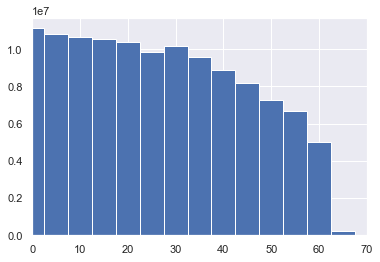

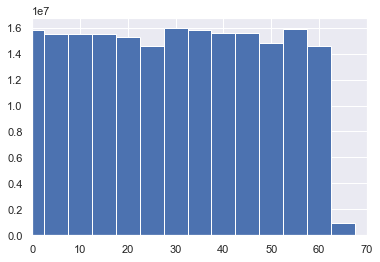

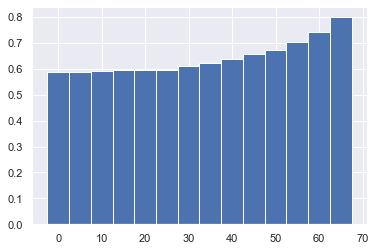

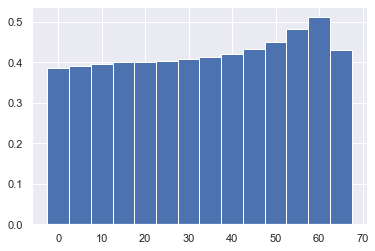

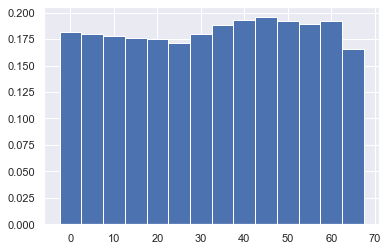

In [61]:


"""n_clear = [x + y for x, y in zip(n_clear, n_clear_new)]
n_cloudy = [x + y for x, y in zip(n_cloudy, n_cloudy_new)]
n_liquid = [x + y for x, y in zip(n_liquid, n_liquid_new)]
n_ice = [x + y for x, y in zip(n_ice, n_ice_new)]


print(len(bins))
print(len(n_clear))

plt.bar(bins[:-1],n_clear,5)
plt.show()
"""


bins=np.arange(0,185,5)
plt.bar(bins[:-1],n_clear,5)
plt.xlim(0,70)
plt.show()


bins=np.arange(0,185,5)
plt.bar(bins[:-1],n_cloudy,5)
plt.xlim(0,70)
plt.show()


cloud_fraction_per_vza = [y/(x+y) for x, y in zip(n_clear, n_cloudy)]

bins=np.arange(0,185,5)

plt.bar(bins[:-1],cloud_fraction_per_vza,5)
plt.show()


liquid_cloud_fraction_per_vza = [z/(x+y) for x, y, z in zip(n_clear, n_cloudy, n_liquid)]

bins=np.arange(0,185,5)

plt.bar(bins[:-1],liquid_cloud_fraction_per_vza,5)
plt.show()


ice_cloud_fraction_per_vza = [z/(x+y) for x, y, z in zip(n_clear, n_cloudy, n_ice)]

bins=np.arange(0,185,5)

plt.bar(bins[:-1],ice_cloud_fraction_per_vza,5)
plt.show()

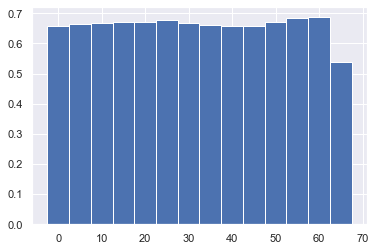

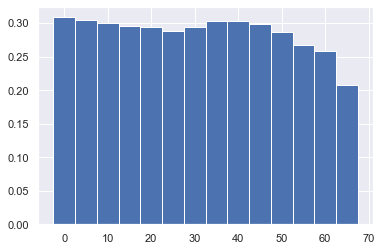

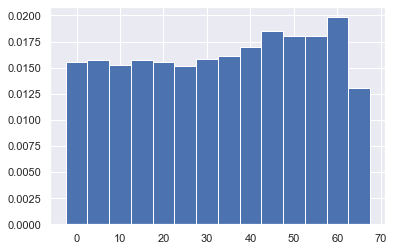

In [58]:
liquid_cloud_fraction_per_vza = [z/(y) for x, y, z in zip(n_clear, n_cloudy, n_liquid)]

bins=np.arange(0,185,5)

plt.bar(bins[:-1],liquid_cloud_fraction_per_vza,5)
plt.show()


ice_cloud_fraction_per_vza = [z/(y) for x, y, z in zip(n_clear, n_cloudy, n_ice)]

bins=np.arange(0,185,5)

plt.bar(bins[:-1],ice_cloud_fraction_per_vza,5)
plt.show()


und_cloud_fraction_per_vza = [z/(y) for x, y, z in zip(n_clear, n_cloudy, n_und)]

bins=np.arange(0,185,5)

plt.bar(bins[:-1],und_cloud_fraction_per_vza,5)
plt.show()

- [C6MOD06OPUserGuide.pdf](https://modis-images.gsfc.nasa.gov/_docs/C6MOD06OPUserGuide.pdf)
- [A machine-learning-based cloud detection and thermodynamicphase classification algorithm using passive spectral observations](https://amt.copernicus.org/articles/13/2257/2020/amt-13-2257-2020.pdf)